In [39]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = rasterio.open('9_1.tif')
y_dataset = rasterio.open('9_1 (1).tif')
all_data = dataset.read()
all_true = y_dataset.read()
all_data.shape, all_true.shape



((10, 512, 512), (1, 512, 512))

In [44]:
plt.imshow(all_true[0])

In [5]:
X = []
for i in range(all_data.shape[1]):
    for j in range(all_data.shape[2]):
        tmp = []
        for k in range(all_data.shape[0]):
            tmp.append(all_data[k, i, j])
            
        X.append(tmp)
X = np.array(X)
print(X.shape)

Y = []
for i in range(all_true.shape[1]):
    for j in range(all_true.shape[2]):
        Y.append(all_true[0, i, j])
Y = np.array(Y)
print(Y.shape)

(262144, 10)
(262144,)


In [6]:
X

array([[1164, 1248, 1328, ..., 1585, 1865, 1653],
       [ 867, 1032, 1184, ..., 1585, 1865, 1653],
       [ 583,  716,  916, ..., 1553, 1834, 1553],
       ...,
       [ 578,  688,  850, ..., 1543, 2234, 1828],
       [ 664,  782,  963, ..., 1652, 2509, 2218],
       [ 678,  828,  982, ..., 1652, 2509, 2218]], dtype=uint16)

In [7]:
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [43]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, Y)
reg.score(X, Y)


0.5541695743696708

In [44]:
reg.coef_

array([-2.43044733e-04,  4.88576773e-04, -1.64091980e-04,  6.77286919e-05,
       -1.52470301e-05,  2.06289977e-04, -2.48484055e-04, -2.38227972e-04,
       -3.47202779e-05, -2.30404365e-04])

In [8]:
from catboost import CatBoostClassifier , Pool
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)
model = CatBoostClassifier(iterations=20000,
                           learning_rate=0.02,
                           depth=2,
                           custom_metric="F1")
eval_dataset = Pool(data=X_test,
                    label=y_test)
train_dataset = Pool(data=X_train,
                     label=y_train)

model.fit(train_dataset, eval_set=eval_dataset)


0:	learn: 0.6663381	test: 0.6662060	best: 0.6662060 (0)	total: 12.8ms	remaining: 4m 15s
1:	learn: 0.6411582	test: 0.6409001	best: 0.6409001 (1)	total: 24.9ms	remaining: 4m 9s
2:	learn: 0.6194987	test: 0.6191559	best: 0.6191559 (2)	total: 36.3ms	remaining: 4m 1s
3:	learn: 0.5975901	test: 0.5971469	best: 0.5971469 (3)	total: 48.2ms	remaining: 4m 1s
4:	learn: 0.5779363	test: 0.5774514	best: 0.5774514 (4)	total: 60.7ms	remaining: 4m 2s
5:	learn: 0.5576357	test: 0.5571301	best: 0.5571301 (5)	total: 75.6ms	remaining: 4m 11s
6:	learn: 0.5388331	test: 0.5383062	best: 0.5383062 (6)	total: 88.2ms	remaining: 4m 11s
7:	learn: 0.5223164	test: 0.5217033	best: 0.5217033 (7)	total: 104ms	remaining: 4m 19s
8:	learn: 0.5097504	test: 0.5090736	best: 0.5090736 (8)	total: 120ms	remaining: 4m 26s
9:	learn: 0.4959968	test: 0.4952922	best: 0.4952922 (9)	total: 134ms	remaining: 4m 28s
10:	learn: 0.4805672	test: 0.4798158	best: 0.4798158 (10)	total: 148ms	remaining: 4m 29s
11:	learn: 0.4686019	test: 0.4677666	b

In [54]:
print(model.score(X_test, y_test))

ValueError: operands could not be broadcast together with shapes (86508,) (1,512,512) 

In [53]:
import tqdm
test = rasterio.open('9_2.tif')
test = test.read()
y_test = rasterio.open('9_2 (1).tif')
y_test = y_test.read()

mask = np.zeros((1,512,512))
X = []
for i in tqdm.tqdm(range(test.shape[1])):
    for j in range(test.shape[2]):
        tmp = []
        for k in range(test.shape[0]):
            tmp.append(test[k, i, j])

        mask[0, i, j] = model.predict_proba([tmp])[0][0]
        X.append(tmp)
X = np.array(X)
print(X.shape)

Y = []
for i in range(y_test.shape[1]):
    for j in range(y_test.shape[2]):
        Y.append(y_test[0, i, j])
Y = np.array(Y)
print(Y.shape)





100%|██████████| 512/512 [01:37<00:00,  5.25it/s]


(262144, 10)
(262144,)


In [55]:
mask[0]

array([[2.00769513e-02, 3.77803743e-01, 9.64794765e-01, ...,
        3.59668899e-01, 3.11104585e-01, 1.33838050e-01],
       [2.32137628e-02, 8.14559896e-03, 6.46905899e-01, ...,
        3.43404648e-01, 3.05438996e-01, 5.09037582e-02],
       [5.33461760e-01, 8.62330548e-03, 3.49228869e-02, ...,
        4.98758969e-01, 2.29056091e-02, 2.34721264e-02],
       ...,
       [3.66702669e-04, 4.45423514e-04, 4.24346941e-04, ...,
        3.87474087e-04, 3.76383452e-04, 3.87279932e-04],
       [4.47779330e-04, 4.28258100e-04, 3.62965851e-04, ...,
        3.85889008e-04, 3.82136340e-04, 3.58140664e-04],
       [3.79127152e-04, 4.32448789e-04, 5.47702885e-04, ...,
        3.85889008e-04, 3.55245353e-04, 3.70499957e-04]])

In [60]:
np.save('mask.npy', mask[0])

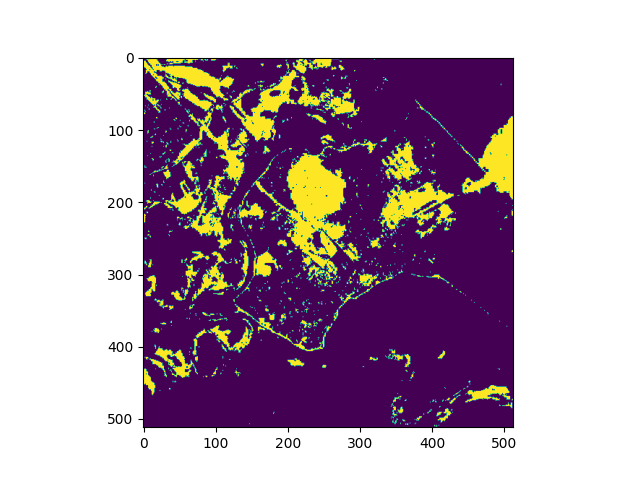

In [61]:
# %matplotlib widget
bin_array = (mask > 0.7).astype(int)
bin_array
np.save('mask.npy', bin_array[0])
plt.imshow(bin_array[0])
plt.show()

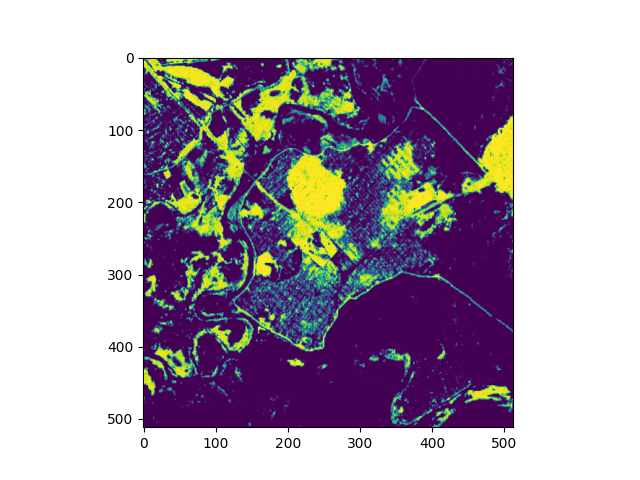

In [57]:
plt.imshow(mask[0])
plt.show()


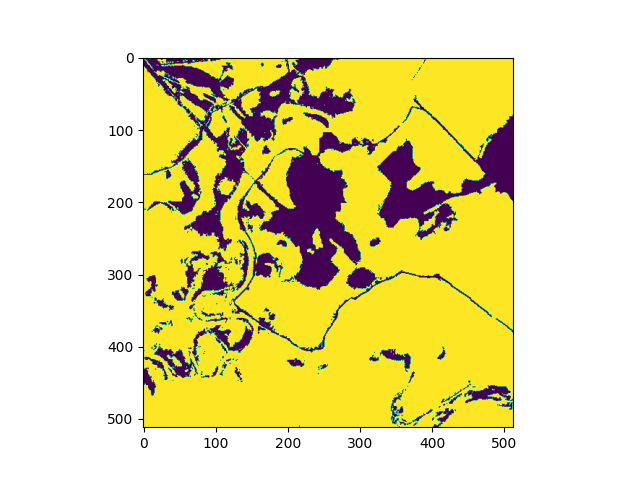

In [58]:
plt.imshow(y_test[0])
plt.show()

In [59]:
model.score(X, Y)

0.9394607543945312